In [73]:
using Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/Desktop/Work/Research/LEGO-project/LEGO-3D_Dyn`


In [74]:
import ForwardDiff as FD
using LinearAlgebra
using Plots

include(joinpath(@__DIR__,"helpers/DEL_dynamics.jl"))
include(joinpath(@__DIR__,"helpers/quaternions.jl"))

quat2rot (generic function with 1 method)

### Simulation paramters

In [86]:
h = 0.01 # 20 Hz
T_final = 5 # final time
T_hist = Array(0:h:T_final)
N = length(T_hist)

# model parameters
params_link1 = (m=1.0, J=Diagonal([0.1, 1.0, 1.0]), g=0) # rigidbody parameters

m1 = params_link1.m
J1 = params_link1.J

# initial conditions
link1_state0 = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] # initial state of the rigidbody
link1_vel0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # initial velocity of the rigidbody
link1_momentum0 = vel2mom(link1_vel0, params_link1) # initial momentum of the rigidbody
# forcing terms
no_forcing = [0 0 0 0 0 0]' # no external forces

# integrate
state_hist = zeros(7, N)
momentum_hist = zeros(6, N)

state_hist[:, 1] = link1_state0
momentum_hist[:, 1] = link1_momentum0

for i in 2:N
  state_hist[:, i], momentum_hist[:, i] = integrator_step(
    hcat(momentum_hist[:, i-1]),
    hcat(state_hist[:, i-1]),
    hcat(no_forcing),
    hcat(no_forcing),
    [params_link1],
    h, 
    max_iters=100)
end

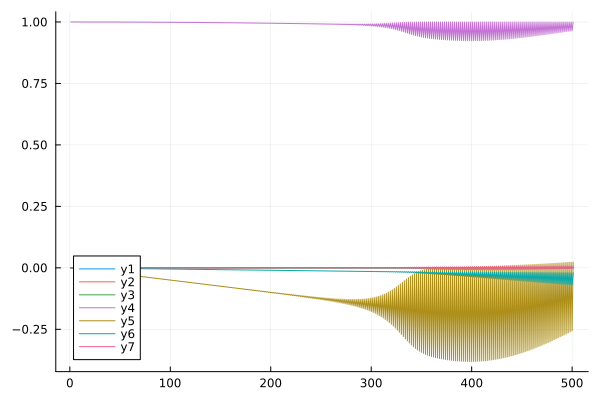

In [87]:
plot(state_hist')

### Visualization

In [88]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [89]:
vis = Visualizer()
render(vis)

┌ Info: Listening on: 127.0.0.1:8704, thread id: 1
└ @ HTTP.Servers /home/sman/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /home/sman/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8704, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8704), "127.0.0.1", "8704", nothing, Sockets.TCPServer(RawFD(58) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007f95997936b0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 140284262322944, 1)))))

In [92]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-0.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"], cylinder1, green_material)


for k = 1:N
    # set position and attitude
    position1 = Translation(state_hist[1:3, k]...)
    attitude1 = LinearMap(UnitQuaternion(state_hist[4:7, k]))

    settransform!(vis["cylinder1"], compose(position1, attitude1))
    sleep(h)
end
